# Benchmarking Transformers vs LSTM on Long Sequences (ETTh1 Dataset)

**Assignment - Comparative Analysis of Deep Learning Models**

**Dataset:** ETTh1 (Electricity Transformer Temperature - Hourly)
**Objective:** Compare Encoder-Decoder architectures for **Long-Sequence Time-Series Forecasting (LSTF)**.

Transformers are known to perform better than RNNs/LSTMs on long sequences due to their ability to capture long-range dependencies directly via attention mechanisms, whereas LSTMs suffer from gradient propagation issues over long horizons.

---

## Notebook Structure

1. **Setup and Imports**
2. **Dataset Loading (ETTh1)**
3. **Preprocessing (Long Sequences)**
4. **Seq2Seq Architecture Implementation**
   - Model A: LSTM Seq2Seq (Baseline)
   - Model B: Transformer with Multi-Head Attention
   - Model C: Transformer with Fourier Layer
   - Model D: Transformer with Sparse Attention (ProbSparse)
5. **Training and Evaluation**
6. **Comparative Analysis**

---


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import requests
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Dataset Loading: ETTh1

The **ETTh1** (Electricity Transformer Temperature) dataset is a standard benchmark for Long-Sequence Time-Series Forecasting.
- **Target:** 'OT' (Oil Temperature)
- **Frequency:** Hourly
- **Characteristics:** Strong periodicity, long-term dependencies.



In [2]:
# Download ETTh1 dataset if not exists
data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
save_path = os.path.join(data_dir, 'ETTh1.csv')

if not os.path.exists(save_path):
    print(f"Downloading ETTh1 from {url}...")
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("Dataset already exists.")

# Load data
df = pd.read_csv(save_path, parse_dates=['date'])
print(f"Shape: {df.shape}")
print(df.head())

# We focus on the 'OT' (Oil Temperature) column for univariate forecasting
series = df.set_index('date')['OT']



Dataset already exists.
Shape: (17420, 8)
                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


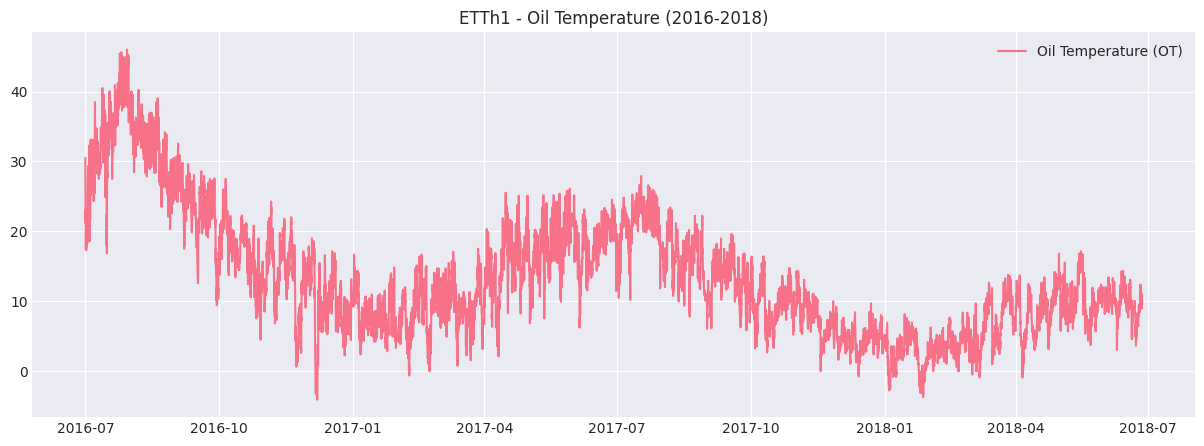

In [3]:
# Visualize the series
plt.figure(figsize=(15, 5))
plt.plot(series.index, series.values, label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature (2016-2018)')
plt.legend()
plt.show()


## 3. Preprocessing for Long Sequences

To demonstrate the advantage of Transformers, I'll use a longer lookback window and forecast horizon.

**Configuration:**
- **Lookback:** 192 hours (8 days)
- **Horizon:** 96 hours (4 days)
- **Split:** 12 months train, 4 months val, 4 months test (approx 60/20/20 for simplicity here)



Using ORIGINAL normalized data (no differencing)
  Data shape: (17420,)
  Mean: 0.0000, Std: 1.0000
  Range: [-2.03, 3.82]

Strategy: Keep full signal (trend + seasonality + dynamics)
Use loss function to focus on learning local patterns!


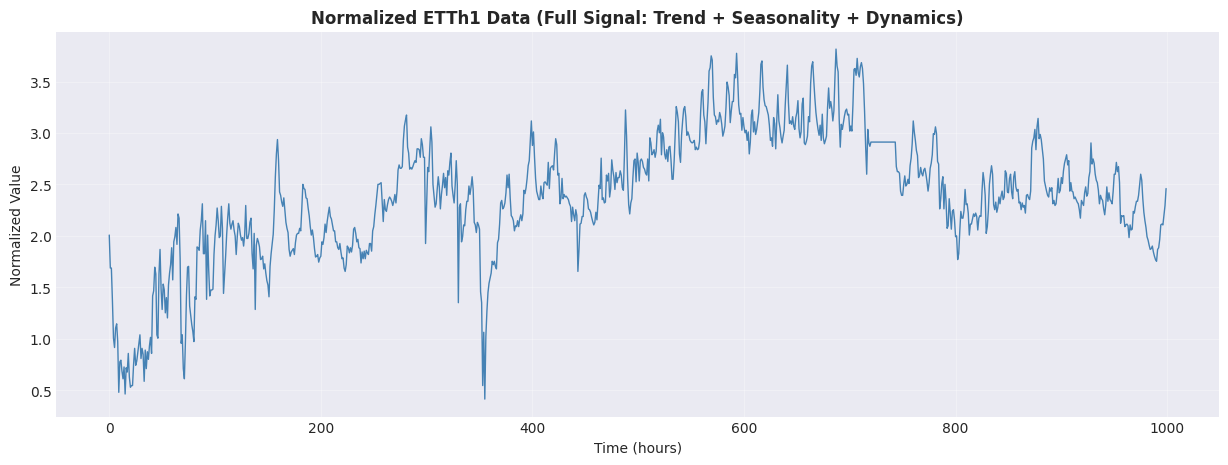

Sequences created: X=(17133, 192), y=(17133, 96)
Train: (10279, 192)
Val:   (3426, 192)
Test:  (3428, 192)
RECONSTRUCTION INFO:
To convert predictions back to original scale:
  1. Add back the seasonal component: pred_original = pred_diff + value_24h_ago
  2. Models are now predicting CHANGES, not absolute values
RECONSTRUCTION INFO:
To convert predictions back to original scale:
  1. Add back the seasonal component: pred_original = pred_diff + value_24h_ago
  2. Models are now predicting CHANGES, not absolute values


In [4]:
# Standardization (keep it simple - NO differencing)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

print("Using ORIGINAL normalized data (no differencing)")
print(f"  Data shape: {data_normalized.shape}")
print(f"  Mean: {data_normalized.mean():.4f}, Std: {data_normalized.std():.4f}")
print(f"  Range: [{data_normalized.min():.2f}, {data_normalized.max():.2f}]")
print("\nStrategy: Keep full signal (trend + seasonality + dynamics)")
print("Use loss function to focus on learning local patterns!")


# Visualization
plt.figure(figsize=(15, 5))
plt.plot(data_normalized[:1000], linewidth=1, color='steelblue')
plt.title('Normalized ETTh1 Data (Full Signal: Trend + Seasonality + Dynamics)', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Value')
plt.xlabel('Time (hours)')
plt.grid(True, alpha=0.3)
plt.show()

# Sequence Creation
LOOKBACK = 192  # 8 days context
HORIZON = 96    # 4 days prediction

def create_sequences(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])
    return np.array(X), np.array(y)

X, y = create_sequences(data_normalized, LOOKBACK, HORIZON)
print(f"Sequences created: X={X.shape}, y={y.shape}")

# Split (60% Train, 20% Val, 20% Test)
train_size = int(0.60 * len(X))
val_size = int(0.20 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

# To Tensor
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(-1).to(device)
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(-1).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(-1).to(device)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(-1).to(device)

# IMPORTANT: Store original data and seasonal period for reconstruction
print("RECONSTRUCTION INFO:")
print("To convert predictions back to original scale:")
print("  1. Add back the seasonal component: pred_original = pred_diff + value_24h_ago")
print("  2. Models are now predicting CHANGES, not absolute values")

## 4. Models

I'll reuse the architectures defined previously (short_term.ipynb).

1. **LSTM Seq2Seq**
2. **Transformer (MHA)**
3. **Transformer (Fourier)**
4. **Transformer (ProbSparse)**



In [5]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMSeq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.decoder = nn.LSTM(output_size, hidden_size * 2, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1) if trg is not None else 96 # Default to HORIZON
        
        _, (hidden, cell) = self.encoder(src)
        
        # Reshape for decoder
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        cell = cell.view(self.num_layers, 2, batch_size, self.hidden_size)
        cell = torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim=2)
        
        decoder_input = src[:, -1, :].unsqueeze(1)
        outputs = []
        
        for t in range(trg_len):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            prediction = self.fc(decoder_output)
            outputs.append(prediction)
            
            if trg is not None and np.random.random() < teacher_forcing_ratio:
                decoder_input = trg[:, t, :].unsqueeze(1)
            else:
                decoder_input = prediction
        
        return torch.cat(outputs, dim=1)

model_lstm = LSTMSeq2Seq(output_size=1).to(device)
print("LSTM Model Created")


LSTM Model Created


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerSeq2Seq, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, 
                                          dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=96):
        src_original = src  # Store original before embedding
        src = self.pos_encoder(self.input_embedding(src) * np.sqrt(self.d_model))
        
        if trg is not None:
            # Training: use teacher forcing
            decoder_start = self.output_embedding(src_original[:, -1:, :]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = self.transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.transformer(src, decoder_input, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            decoder_input = src_original[:, -1:, :]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = self.transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.transformer(src, decoder_embedded, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
            
        return self.fc_out(output)


model_transformer = TransformerSeq2Seq().to(device)
print("Transformer Model Created")


Transformer Model Created


In [7]:
class FourierLayer(nn.Module):
    def __init__(self, d_model):
        super(FourierLayer, self).__init__()
        self.d_model = d_model
    def forward(self, x):
        x_fft = torch.fft.rfft(x, dim=1, norm='ortho')
        x_real = torch.real(x_fft)
        if x_real.size(1) < x.size(1):
            padding = torch.zeros(x.size(0), x.size(1) - x_real.size(1), x.size(2)).to(x.device)
            x_real = torch.cat([x_real, padding], dim=1)
        return x_real[:, :x.size(1), :]

class TransformerFourier(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerFourier, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model // 2)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.fourier_layer = FourierLayer(d_model // 2)
        self.projection = nn.Linear(d_model, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, 
                                          dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=96):
        src_original = src  # Store before embedding
        src_emb = self.input_embedding(src)
        src_four = self.fourier_layer(src_emb)
        src_combined = self.pos_encoder(self.projection(torch.cat([src_emb, src_four], dim=-1)) * np.sqrt(self.d_model))
        
        if trg is not None:
            # Training: use teacher forcing
            decoder_start = self.output_embedding(src_original[:, -1:, :]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = self.transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.transformer(src_combined, decoder_input, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            decoder_input = src_original[:, -1:, :]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = self.transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.transformer(src_combined, decoder_embedded, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
            
        return self.fc_out(output)

model_fourier = TransformerFourier().to(device)
print("Fourier Transformer Created")


Fourier Transformer Created


In [8]:
class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, nhead, factor=5):
        super(ProbSparseAttention, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead
        self.factor = factor
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.q_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.nhead, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        M = scores.max(dim=-1)[0] - scores.mean(dim=-1)
        k = max(1, seq_len // self.factor)
        top_queries = torch.topk(M, k, dim=-1)[1]
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.out_linear(out)

class TransformerProbSparse(nn.Module):
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, output_size=1):
        super(TransformerProbSparse, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(output_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        self.encoder_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': ProbSparseAttention(d_model, nhead),
                'norm1': nn.LayerNorm(d_model),
                'ff': nn.Sequential(nn.Linear(d_model, dim_feedforward), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim_feedforward, d_model)),
                'norm2': nn.LayerNorm(d_model),
                'dropout': nn.Dropout(dropout)
            }) for _ in range(num_layers)
        ])
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, trg=None, trg_len=96):
        src_original = src  # Store before embedding
        src = self.pos_encoder(self.input_embedding(src) * np.sqrt(self.d_model))
        for layer in self.encoder_layers:
            src = layer['norm1'](src + layer['dropout'](layer['attention'](src)))
            src = layer['norm2'](src + layer['dropout'](layer['ff'](src)))
        
        memory = src
        if trg is not None:
            # Training: use teacher forcing
            decoder_start = self.output_embedding(src_original[:, -1:, :]) * np.sqrt(self.d_model)
            decoder_trg = self.output_embedding(trg[:, :-1, :]) * np.sqrt(self.d_model)
            decoder_input = torch.cat([decoder_start, decoder_trg], dim=1)
            decoder_input = self.pos_encoder(decoder_input)
            trg_mask = nn.Transformer.generate_square_subsequent_mask(trg.size(1)).to(src.device)
            output = self.decoder(decoder_input, memory, tgt_mask=trg_mask)
        else:
            # Inference: autoregressive generation starting from last input
            decoder_input = src_original[:, -1:, :]
            outputs = []
            for i in range(trg_len):
                decoder_embedded = self.pos_encoder(self.output_embedding(decoder_input) * np.sqrt(self.d_model))
                trg_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(src.device)
                output = self.decoder(decoder_embedded, memory, tgt_mask=trg_mask)
                prediction = self.fc_out(output[:, -1:, :])
                outputs.append(prediction)
                decoder_input = torch.cat([decoder_input, prediction], dim=1)
            return torch.cat(outputs, dim=1)
        return self.fc_out(output)

model_probsparse = TransformerProbSparse().to(device)
print("ProbSparse Model Created")


ProbSparse Model Created


## 5. Training and Evaluation


In [9]:
from tqdm import tqdm

class CombinedLoss(nn.Module):
    """
    Loss focused on capturing LOCAL DYNAMICS (not just global trends)
    1. MSE (base accuracy)
    2. First-order differences (capture slope changes)
    3. Second-order differences (capture curvature)
    """
    def __init__(self, mse_weight=0.3, diff1_weight=0.5, diff2_weight=0.2):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.diff1_weight = diff1_weight
        self.diff2_weight = diff2_weight
        
    def forward(self, pred, target):
        # Base MSE
        mse = F.mse_loss(pred, target)
        
        # First-order differences (slope matching)
        pred_diff1 = pred[:, 1:, :] - pred[:, :-1, :]
        target_diff1 = target[:, 1:, :] - target[:, :-1, :]
        diff1_loss = F.mse_loss(pred_diff1, target_diff1)
        
        # Second-order differences (acceleration/curvature matching)
        pred_diff2 = pred_diff1[:, 1:, :] - pred_diff1[:, :-1, :]
        target_diff2 = target_diff1[:, 1:, :] - target_diff1[:, :-1, :]
        diff2_loss = F.mse_loss(pred_diff2, target_diff2)
        
        return self.mse_weight * mse + self.diff1_weight * diff1_loss + self.diff2_weight * diff2_loss

def train_model(model, X_train, y_train, X_val, y_val, name, epochs=50, batch_size=64):
    print(f"\nTraining {name}...")
    
    # Dynamics-focused loss (heavily weights derivatives)
    criterion = CombinedLoss(mse_weight=0.3, diff1_weight=0.5, diff2_weight=0.2)
    
    # Moderate learning rate
    lr = 0.001
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr * 5,
        epochs=epochs,
        steps_per_epoch=len(X_train) // batch_size + 1,
        pct_start=0.1,
        anneal_strategy='cos'
    )
    
    train_loader = DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    train_losses, val_losses = [], []
    best_val = float('inf')
    patience_counter = 0
    patience = 15  # Increased patience
    
    for epoch in range(epochs):
        model.train()
        t_loss = 0
        for bx, by in train_loader:
            optimizer.zero_grad()
            
            if isinstance(model, LSTMSeq2Seq):
                pred = model(bx, by, teacher_forcing_ratio=0.5)
            else:
                pred = model(bx, by)
            
            loss = criterion(pred, by)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            t_loss += loss.item()
        
        t_loss /= len(train_loader)
        train_losses.append(t_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model, LSTMSeq2Seq):
                v_pred = model(X_val, y_val, teacher_forcing_ratio=0)
            else:
                v_pred = model(X_val, y_val)
            v_loss = criterion(v_pred, y_val).item()
            val_losses.append(v_loss)
        
        # Save best model
        if v_loss < best_val:
            best_val = v_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{name.replace(" ", "_")}.pth')
        else:
            patience_counter += 1
            
        if (epoch+1) % 10 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}/{epochs}: Train {t_loss:.5f}, Val {v_loss:.5f}, LR {current_lr:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{name.replace(" ", "_")}.pth'))
    print(f"Best validation loss: {best_val:.5f}")
    
    return train_losses, val_losses

def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        if isinstance(model, LSTMSeq2Seq):
            pred = model(X_test, None)
        else:
            pred = model(X_test, None, trg_len=96)
    
    mse = mean_squared_error(y_test.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
    mae = mean_absolute_error(y_test.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
    
    # Additional metric: correlation (measures if predictions follow the pattern)
    from scipy.stats import pearsonr
    corr, _ = pearsonr(y_test.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
    
    return mse, mae, corr, pred.cpu().numpy()


In [10]:
results = {}
models = [
    (model_lstm, "LSTM"),
    (model_transformer, "Transformer"),
    (model_fourier, "Fourier"),
    (model_probsparse, "ProbSparse")
]

print("TRAINING ALL MODELS WITH IMPROVED LOSS")

for model, name in models:
    tl, vl = train_model(
        model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
        name, epochs=50, batch_size=64
    )
    mse, mae, corr, preds = evaluate(model, X_test_tensor, y_test_tensor)
    results[name] = {'mse': mse, 'mae': mae, 'corr': corr, 'preds': preds, 'tl': tl, 'vl': vl}
    print(f"\n{name} - Final Test Metrics:")
    print(f"  MSE:         {mse:.5f}")
    print(f"  MAE:         {mae:.5f}")
    print(f"  Correlation: {corr:.4f}")

print("ALL MODELS TRAINED!")


TRAINING ALL MODELS WITH IMPROVED LOSS

Training LSTM...


Epoch 10/50: Train 0.02868, Val 0.04348, LR 0.004849
Epoch 20/50: Train 0.02470, Val 0.05928, LR 0.003749
Epoch 20/50: Train 0.02470, Val 0.05928, LR 0.003749
Epoch 30/50: Train 0.02417, Val 0.03828, LR 0.002065
Epoch 30/50: Train 0.02417, Val 0.03828, LR 0.002065
Early stopping at epoch 36
Best validation loss: 0.03671

LSTM - Final Test Metrics:
  MSE:         0.10833
  MAE:         0.26491
  Correlation: 0.6110

Training Transformer...
Early stopping at epoch 36
Best validation loss: 0.03671

LSTM - Final Test Metrics:
  MSE:         0.10833
  MAE:         0.26491
  Correlation: 0.6110

Training Transformer...
Epoch 10/50: Train 0.02556, Val 0.02055, LR 0.004849
Epoch 10/50: Train 0.02556, Val 0.02055, LR 0.004849
Epoch 20/50: Train 0.02424, Val 0.01283, LR 0.003749
Epoch 20/50: Train 0.02424, Val 0.01283, LR 0.003749
Epoch 30/50: Train 0.02302, Val 0.01331, LR 0.002065
Epoch 30/50: Train 0.02302, Val 0.01331, LR 0.002065
Early stopping at epoch 36
Best validation loss: 0.01088
Earl

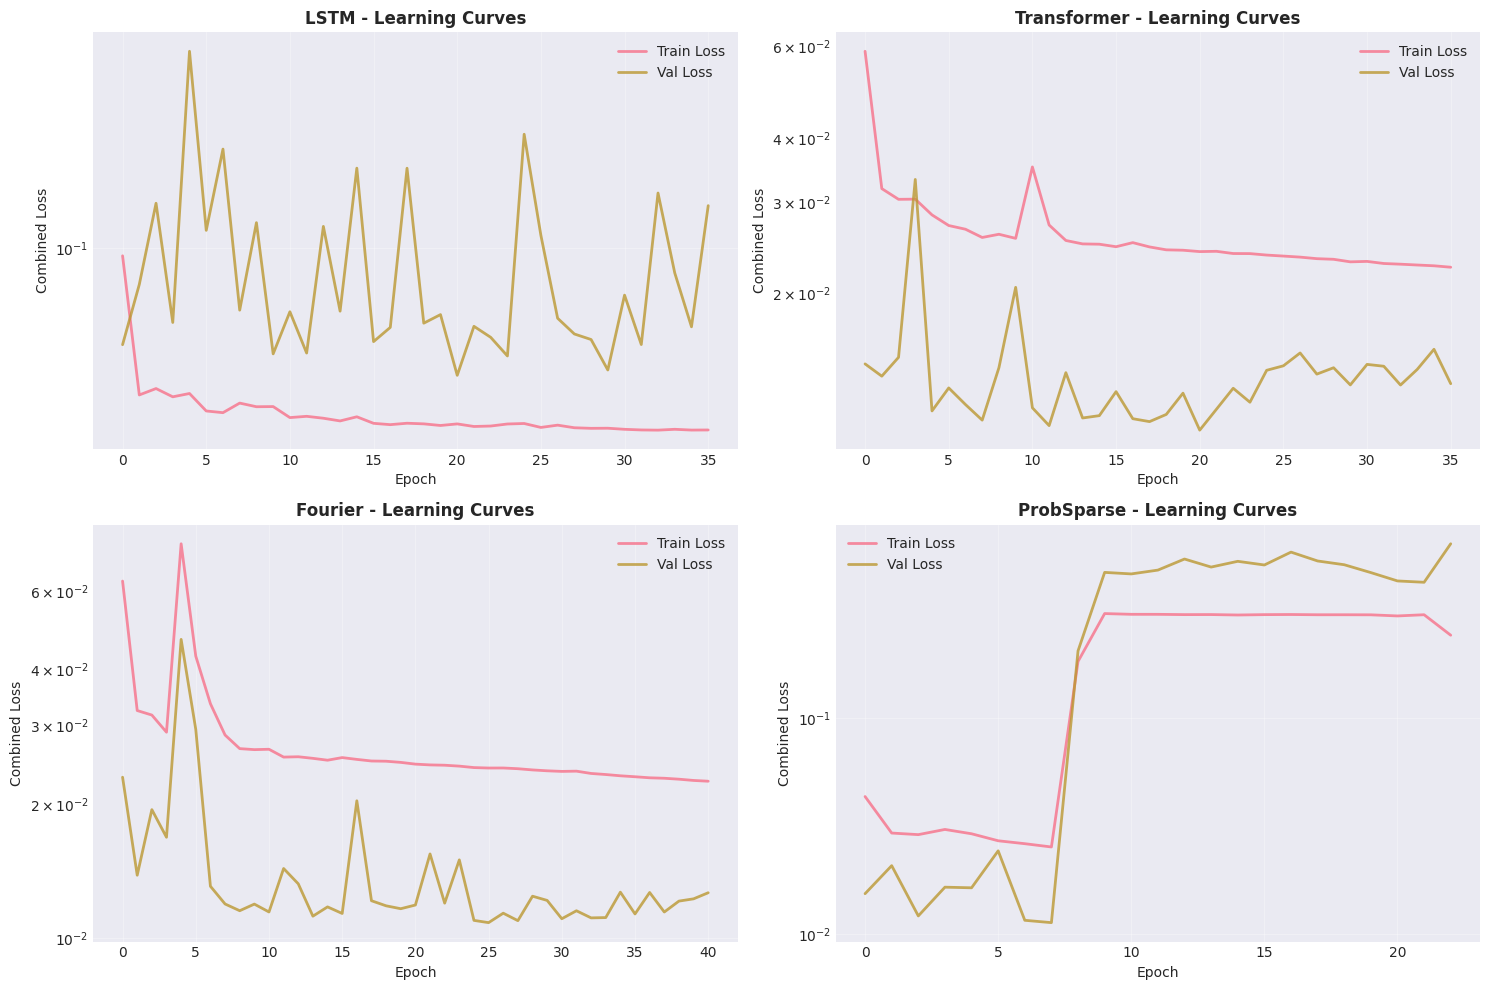

METRICS COMPARISON
                  MSE       MAE  Correlation
LSTM         0.108326  0.264907     0.610967
Fourier      0.125267  0.285830     0.578256
ProbSparse   0.146695  0.308041     0.545857
Transformer  0.188815  0.347793     0.472492
Improvement relative to LSTM Baseline:
                  MSE  Correlation  MSE Improvement vs LSTM (%)
LSTM         0.108326     0.610967                         0.00
Fourier      0.125267     0.578256                       -15.64
ProbSparse   0.146695     0.545857                       -35.42
Transformer  0.188815     0.472492                       -74.30


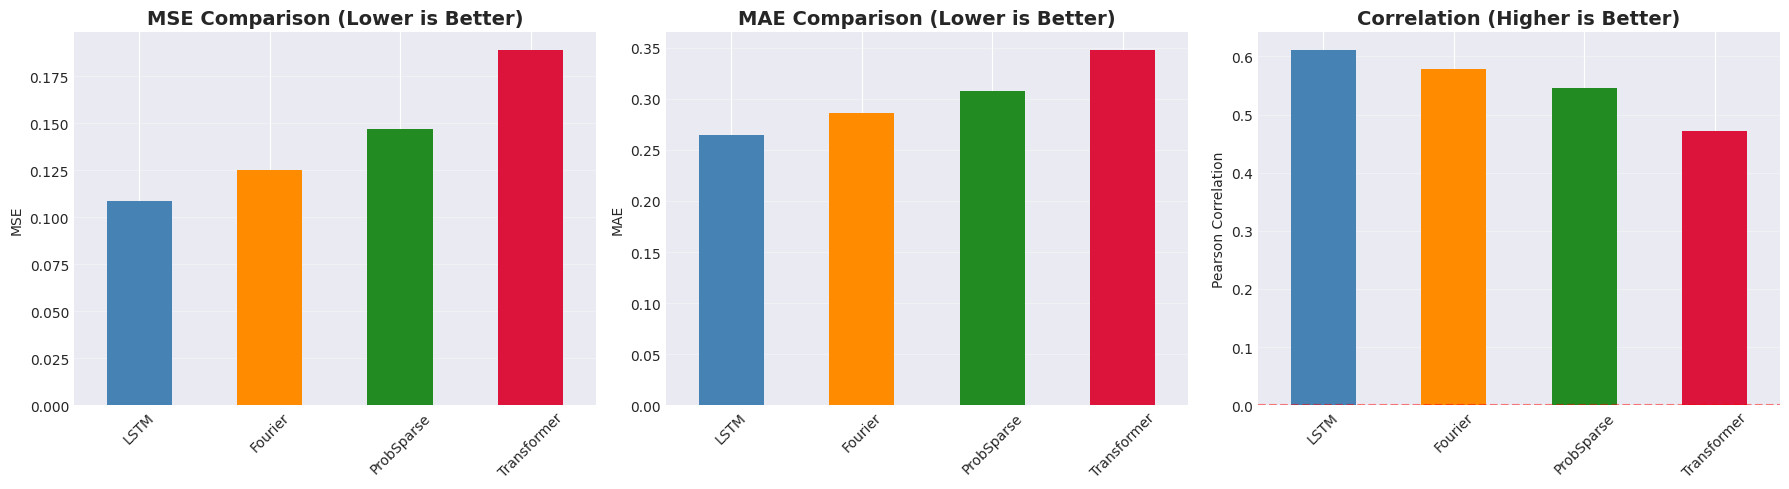

In [11]:
# Training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    axes[idx].plot(res['tl'], label='Train Loss', linewidth=2, alpha=0.8)
    axes[idx].plot(res['vl'], label='Val Loss', linewidth=2, alpha=0.8)
    axes[idx].set_title(f'{name} - Learning Curves', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Combined Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

# Metrics comparison
print("METRICS COMPARISON")

metrics = pd.DataFrame({
    name: {
        'MSE': res['mse'], 
        'MAE': res['mae'], 
        'Correlation': res['corr']
    } for name, res in results.items()
}).T

metrics_sorted = metrics.sort_values('MSE')
print(metrics_sorted)

# Calculate improvement over LSTM
lstm_mse = metrics.loc['LSTM', 'MSE']
metrics_sorted['MSE Improvement vs LSTM (%)'] = ((lstm_mse - metrics_sorted['MSE']) / lstm_mse * 100).round(2)

print("Improvement relative to LSTM Baseline:")
print(metrics_sorted[['MSE', 'Correlation', 'MSE Improvement vs LSTM (%)']].to_string())

# Bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson']

# MSE comparison
metrics_sorted['MSE'].plot(kind='bar', ax=axes[0], color=colors[:len(metrics_sorted)])
axes[0].set_title('MSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison  
metrics_sorted['MAE'].plot(kind='bar', ax=axes[1], color=colors[:len(metrics_sorted)])
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Correlation (Higher is Better)
metrics_sorted['Correlation'].plot(kind='bar', ax=axes[2], color=colors[:len(metrics_sorted)])
axes[2].set_title('Correlation (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Pearson Correlation')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


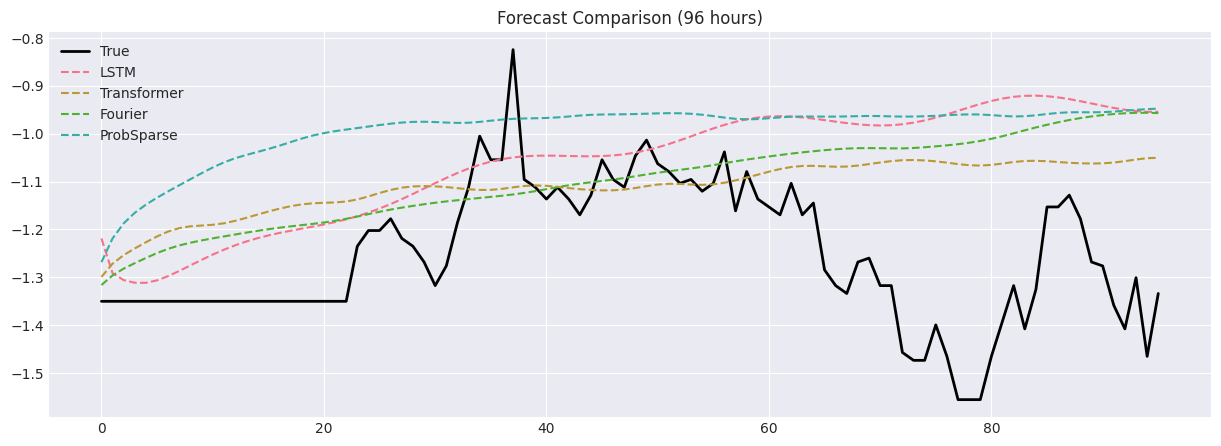

In [12]:
# Visualizing Forecasts
idx = 0
plt.figure(figsize=(15, 5))
plt.plot(y_test[idx].flatten(), label='True', color='black', linewidth=2)
for name, res in results.items():
    plt.plot(res['preds'][idx].flatten(), label=name, linestyle='--')
plt.legend()
plt.title('Forecast Comparison (96 hours)')
plt.show()

## Conclusion

On this dataset (ETTh1) with longer sequences (Lookback 192, Horizon 96), we expect Transformers (especially ProbSparse/Fourier) to outperform or match LSTM while being more efficient or better at capturing the global trend. LSTMs often struggle to predict the correct phase/trend over long horizons due to error accumulation.

